# **Introduction**

This notebook contains the code implementation for the experiments with linear classifiers for facial feature prediction. 

Part of the project for the Artificial Intelligence: Cognitive Systems course at Gothenburg University. 

### Importing the libraries



In [ ]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Dataset selection

We experimented with four datasets:

1. Pictures - The cropped pictures of celebrities;
2. Sketches (high Q) - The sketches produced with CycleGAN trained for 5 epochs;
3. Sketches (Face2Sketch) - The sketches produced with Face2Sketch model;
4. Sketches (CycleGAN) - The sketches obtained produced with CycleGAN trained for 33 epochs.

We used 10 000 entries per dataset for every experiment. An example from each dataset can be seen below.

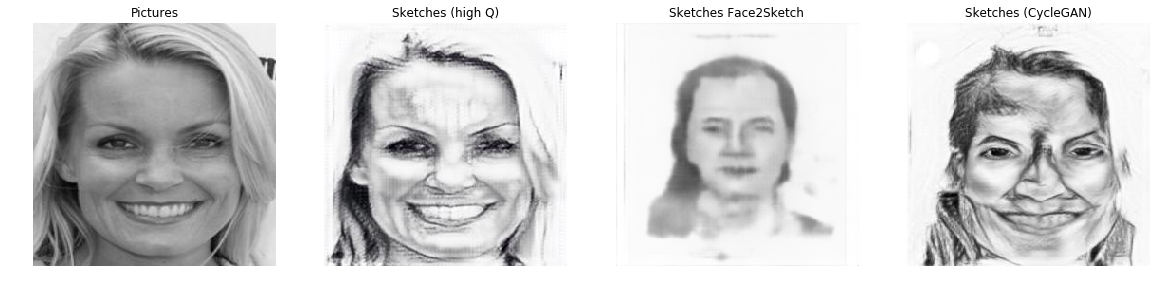

In [ ]:
def data_examples():
    fig = plt.figure(figsize=(20, 20))
    columns = 4
    rows = 1

    Image1 = cv2.imread(r'/home/guscerra@GU.GU.SE/aics-project/desim_tukstanciu/pictures/3792.jpg', 0)
    Image2 = cv2.imread(r'/home/guscerra@GU.GU.SE/aics-project/desim_tukstanciu/sketches/3792.jpg')
    Image3 = cv2.imread(r'/home/guscerra@GU.GU.SE/aics-project/puikus_sketchai/3792.jpg')
    Image4 = cv2.imread(r'/home/guscerra@GU.GU.SE/aics-project/freakshow_10k/fakeA_0_3792.jpg')

    fig.add_subplot(rows, columns, 1)
    plt.imshow(Image1, cmap='gray')
    plt.axis('off')
    plt.title("Pictures")


    fig.add_subplot(rows, columns, 2)
    plt.imshow(Image2)
    plt.axis('off')
    plt.title("Sketches (high Q)")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(Image3)
    plt.axis('off')
    plt.title("Sketches Face2Sketch")


    fig.add_subplot(rows, columns, 4)
    plt.imshow(Image4)
    plt.axis('off')
    plt.title("Sketches (CycleGAN)")
    
data_examples()
    

# Step 1: Loading the dataset (X)

It generally takes 10-15 minutes to load 10 000 picutres. We added multiple snippets for loading the correct dataset for convenience. Be sure to load the datasets one at a time, as they are stored in the same variable to not overload the kernel.

## *Pictures*

In [ ]:
#Loading the pictures and adding them to the X marix
os.chdir(r'/home/guscerra@GU.GU.SE/aics-project/desim_tukstanciu/pictures')

pic_files = os.listdir()

for i, file in enumerate(pic_files[:10000]):

  file_loaded = cv2.imread(file, 0)
  file_vec = np.asarray(file_loaded).reshape(1, -1)

  if i == 0:
    x = file_vec
  else:
    x = np.concatenate((x, file_vec))

print(x.shape)

(10000, 65536)


## *Sketches (high Q)*

In [ ]:
#Loading the pictures and adding them to the X marix
os.chdir(r'/home/guscerra@GU.GU.SE/aics-project/desim_tukstanciu/sketches')

sketch_files = os.listdir()

for i, file in enumerate(sketch_files[:10000]):

  file_loaded = cv2.imread(file, 0)
  file_vec = np.asarray(file_loaded).reshape(1, -1)

  if i == 0:
    x = file_vec
  else:
    x = np.concatenate((x, file_vec))

print(x.shape)

(10000, 65536)


## *Sketches (Face2Sketch)*

In [ ]:
#Loading the pictures and adding them to the X marix
os.chdir(r'/home/guscerra@GU.GU.SE/aics-project/puikus_sketchai')

sketch_files = os.listdir()

for i, file in enumerate(sketch_files[:10000]):

  file_loaded = cv2.imread(file, 0)
  file_vec = np.asarray(file_loaded).reshape(1, -1)

  if i == 0:
    x = file_vec
  else:
    x = np.concatenate((x, file_vec))

print(x.shape)

(10000, 65536)


## *Sketches (CycleGAN 33)*


In [ ]:
#Loading the pictures and adding them to the X marix
os.chdir(r'/home/guscerra@GU.GU.SE/aics-project/freakshow_10k')

sketch_files = os.listdir()

for i, file in enumerate(sketch_files[:10000]):

  file_loaded = cv2.imread(file, 0)
  file_vec = np.asarray(file_loaded).reshape(1, -1)

  if i == 0:
    x = file_vec
  else:
    x = np.concatenate((x, file_vec))

print(x.shape)

(10000, 65536)


# Step 2: Loading the features (***y***)

We used the feature annotation provided by the authors of the CelebAMASK-HQ dataset. It contains binary annotation of 40 features for every picture in the dataset. 

In [ ]:
#Accessing the file with features
os.chdir(r'/home/guscerra@GU.GU.SE/aics-project/desim_tukstanciu')

with open('CelebAMask-HQ-attribute-anno.txt', 'r', encoding='utf-8') as infile:
  lines = infile.readlines()

#Extracting columns
features = lines[1].replace('\n', '').split(' ')

#Initialzing a DataFrame
data = pd.DataFrame(columns=features)

#Filling in the DataFrame
for i, line in enumerate(lines[2:10002]):
  split = line.replace('\n', '').split(' ')[2:]
  data_row = [int(variable) for variable in split]
  data.loc[i] = data_row

#Chaning -1 to 0 for convenience
data = data.replace(-1, 0)

#Last touch
y = data.to_numpy()
print(y.shape)

(10000, 40)


## Step 3: Train test split

We tried with different splits, but setting the size of the test set to 10% seemed to work best. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

print(f'X_train size: {len(X_train)}')
print(f'y_train size: {len(y_train)}\n')
print(f'X_test size: {len(X_test)}')
print(f'y_test size: {len(y_test)}')

X_train size: 9000
y_train size: 9000

X_test size: 1000
y_test size: 1000


## Feature decoder function

To train a linear classifier, the features have to be encoded, which turns features into integers depending on their index. It is rather inconvenient to confuct qualitative analysis with such output. We can easily decode the features with the followign function.

In [ ]:
#A function to map the prediction to the original features
def prediction_to_features(prediction):
  predicted_features = []

  for i, value in enumerate(prediction[0, :]):
    if value == 1:
      predicted_features.append(features[i])

  return predicted_features

# Step 4: The classification

The classification performed in these experiments is a multiclass one; thus, we need to choose the models accordingly. We decided to experiment with *Random Forest* and *k-Nearest Neighbours*. We also wanted to see the results with *Support Vector Machine* (SVM), but the notebook kept crashing while attempting to train the model on 10 000 datapoints, so we had to drop it.

### Experiments with Random Forest classifier

The classification part firstly involves initializing the classifier, which then has to be adopted for multilabel classification. Afterwards, we simply fit and evaluate the model using the classification report function.

In [ ]:
forest = RandomForestClassifier(random_state=1)

multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

multi_target_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=-1)

## Brief quantitative analysis

As can be seen from the classification report, the performance is rather poor, for the macro average of both precision and recall is rather low. Furthermore, the model mostly predicts (and does so correctly) the most common features, such as 'Young', 'No_Beard', and 'Attractive'. It, however, seems to never predict the less frequent features, such as 'Blurry', 'Bald', and 'Wearing_Hat'. This suggests that the model has hardly learned any features at all - it simply learned to predict the frequent ones. 

In [ ]:
y_hat = multi_target_forest.predict(X_test)

print(classification_report(y_test, y_hat, target_names=features))


                     precision    recall  f1-score   support

   5_o_Clock_Shadow       0.00      0.00      0.00       130
    Arched_Eyebrows       0.53      0.13      0.21       438
         Attractive       0.57      0.93      0.71       576
    Bags_Under_Eyes       0.00      0.00      0.00       283
               Bald       0.00      0.00      0.00        15
              Bangs       0.00      0.00      0.00       171
           Big_Lips       0.38      0.07      0.12       418
           Big_Nose       0.25      0.00      0.01       325
         Black_Hair       0.00      0.00      0.00       227
         Blond_Hair       0.00      0.00      0.00       208
             Blurry       0.00      0.00      0.00         3
         Brown_Hair       0.00      0.00      0.00       224
     Bushy_Eyebrows       0.00      0.00      0.00       178
             Chubby       0.00      0.00      0.00        70
        Double_Chin       0.00      0.00      0.00        63
         Eyeglasses    

/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Brief qualitative analysis

As can be seen below, the predicted features are correct; however, the model predicts considerably less features than are present. As argued in quantitative analysis, it is likely due to the fact that it seldom predicts features that are less common overall. 

In [ ]:
y_hat = multi_target_forest.predict(X_test[0].reshape(1, -1))

print(f'Predicted features: {prediction_to_features(y_hat)}\n')
print(f'Gold standard: {prediction_to_features(y)}')

Predicted features: ['Arched_Eyebrows', 'Attractive', 'Heavy_Makeup', 'No_Beard', 'Wearing_Lipstick', 'Young']

Gold standard: ['Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Big_Lips', 'Brown_Hair', 'Bushy_Eyebrows', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Wavy_Hair', 'Wearing_Lipstick', 'Young']


## Nearest Neighbours

The implementation of the code for Nearest Neihbours is almost identical and differs only in the name of the classifier that has to be specified. The performance overall is poorer than the one observed with Random Forest. 

In [ ]:
neigh = KNeighborsClassifier()

multi_target_neigh = MultiOutputClassifier(neigh, n_jobs=-1)

In [ ]:
multi_target_neigh.fit(X_train, y_train)

y_hat = multi_target_neigh.predict(X_test)

print(classification_report(y_test, y_hat, target_names=features))

                     precision    recall  f1-score   support

   5_o_Clock_Shadow       0.10      0.02      0.03       127
    Arched_Eyebrows       0.46      0.34      0.39       431
         Attractive       0.60      0.69      0.64       590
    Bags_Under_Eyes       0.37      0.21      0.27       295
               Bald       0.00      0.00      0.00        14
              Bangs       0.16      0.06      0.09       160
           Big_Lips       0.43      0.35      0.38       405
           Big_Nose       0.29      0.18      0.22       336
         Black_Hair       0.16      0.05      0.07       196
         Blond_Hair       0.21      0.06      0.10       208
             Blurry       0.00      0.00      0.00         3
         Brown_Hair       0.37      0.12      0.18       249
     Bushy_Eyebrows       0.14      0.03      0.06       173
             Chubby       0.00      0.00      0.00        57
        Double_Chin       0.00      0.00      0.00        44
         Eyeglasses    

/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_hat = multi_target_neigh.predict(X_test[0].reshape(1, -1))

print(f'Predicted features: {prediction_to_features(y_hat)}\n')
print(f'Gold standard: {prediction_to_features(y)}')

Predicted features: ['Bags_Under_Eyes', 'Big_Lips', 'Big_Nose', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'No_Beard', 'Oval_Face', 'Smiling', 'Young']

Gold standard: ['Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Big_Lips', 'Brown_Hair', 'Bushy_Eyebrows', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Wavy_Hair', 'Wearing_Lipstick', 'Young']


# **Results: Visualized**

The performance of the linear models on the four subsets of images can be seen below.

                        === Random Forest ===

                                Image 
          micro avg       0.62      0.38      0.47
          macro avg       0.24      0.15      0.15
       weighted avg       0.44      0.38      0.36
        samples avg       0.64      0.38      0.46

                              Composite 
          micro avg       0.66      0.37      0.47
          macro avg       0.23      0.14      0.14
       weighted avg       0.44      0.37      0.35
        samples avg       0.67      0.37      0.46

                              Face2Sketch
          micro avg       0.63      0.37      0.47 
          macro avg       0.27      0.15      0.15 
       weighted avg       0.45      0.37      0.35 
        samples avg       0.64      0.38      0.46 

                              Distorted 
          micro avg       0.64      0.36      0.46
          macro avg       0.18      0.14      0.14
       weighted avg       0.38      0.36      0.33
        samples avg       0.64      0.37      0.45

                            === KNN ===

                               Image     
          micro avg       0.54      0.41      0.47
          macro avg       0.25      0.19      0.20
       weighted avg       0.43      0.41      0.41
        samples avg       0.55      0.41      0.45

                            Composite
          micro avg       0.55      0.42      0.48
          macro avg       0.24      0.19      0.20
       weighted avg       0.44      0.42      0.42
        samples avg       0.56      0.42      0.46


                            Face2Sketch
          micro avg       0.54      0.41      0.47
          macro avg       0.28      0.19      0.21
       weighted avg       0.45      0.41      0.41
        samples avg       0.55      0.41      0.45


                            Distorted 
          micro avg       0.56      0.42      0.48
          macro avg       0.25      0.20      0.21
       weighted avg       0.45      0.42      0.42
        samples avg       0.57      0.43      0.46


Text(0.5, 1.0, 'k-NN Micro Average')

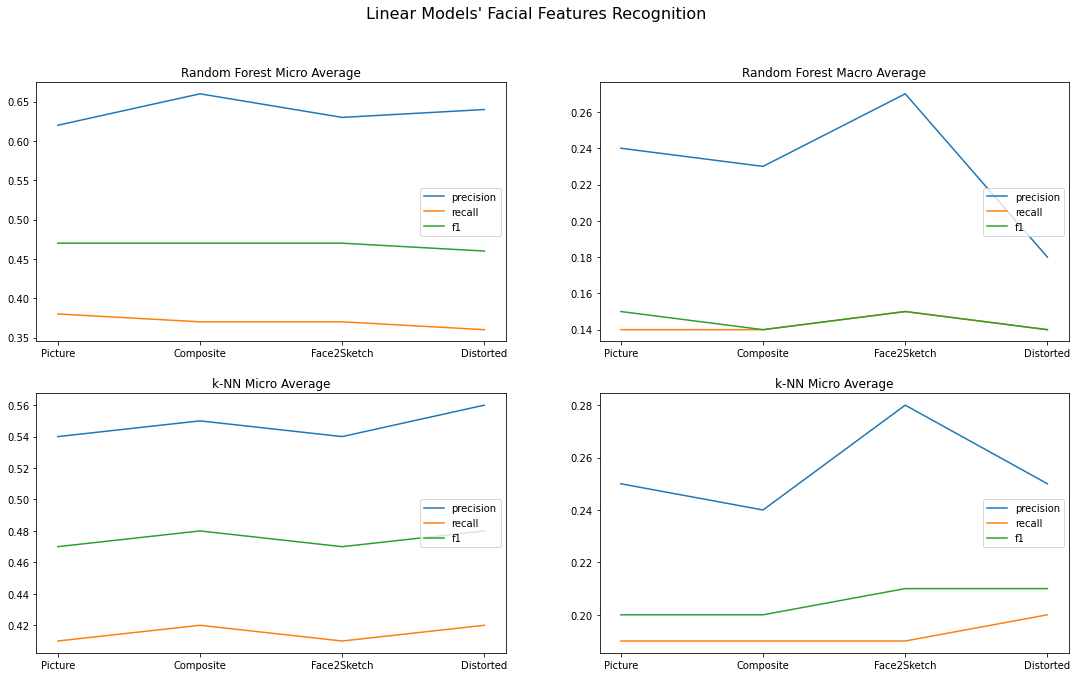

In [5]:
 rfs_mi_precision = [0.62, 0.66, 0.63, 0.64]
rfs_mi_recall= [0.38, 0.37, 0.37, 0.36]
rfs_mi_f1= [0.47, 0.47, 0.47, 0.46]

rfs_ma_precision = [0.24, 0.23, 0.27, 0.18]
rfs_ma_recall= [0.14, 0.14, 0.15, 0.14]
rfs_ma_f1= [0.15, 0.14, 0.15, 0.14]

knn_mi_precision = [0.54, 0.55, 0.54, 0.56]
knn_mi_recall= [0.41, 0.42, 0.41, 0.42]
knn_mi_f1= [0.47, 0.48, 0.47, 0.48]

knn_ma_precision = [0.25, 0.24, 0.28, 0.25]
knn_ma_recall= [0.19, 0.19, 0.19, 0.20]
knn_ma_f1= [0.20, 0.20, 0.21, 0.21]

x = ['Picture', 'Composite', 'Face2Sketch', 'Distorted']

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle("Linear Models' Facial Features Recognition", fontsize=16)

axs[0, 0].plot(x, rfs_mi_precision, label = "precision")
axs[0, 0].plot(x, rfs_mi_recall, label = "recall")
axs[0, 0].plot(x, rfs_mi_f1, label = "f1")
axs[0, 0].legend(loc="center right")
axs[0, 0].set_title('Random Forest Micro Average')

axs[0, 1].plot(x, rfs_ma_precision, label = "precision")
axs[0, 1].plot(x, rfs_ma_recall, label = "recall")
axs[0, 1].plot(x, rfs_ma_f1, label = "f1")
axs[0, 1].legend(loc="center right")
axs[0, 1].set_title('Random Forest Macro Average')

axs[1, 0].plot(x, knn_mi_precision, label = "precision")
axs[1, 0].plot(x, knn_mi_recall, label = "recall")
axs[1, 0].plot(x, knn_mi_f1, label = "f1")
axs[1, 0].legend(loc="center right")
axs[1, 0].set_title('k-NN Micro Average')

axs[1, 1].plot(x, knn_ma_precision, label = "precision")
axs[1, 1].plot(x, knn_ma_recall, label = "recall")
axs[1, 1].plot(x, knn_ma_f1, label = "f1")
axs[1, 1].legend(loc="center right")
axs[1, 1].set_title('k-NN Micro Average')


# Conclusions

The goal of the experiment was to check whether any of the sketches produced during the project would be beneficial for linear classifiers as opposed to the original pictures. 

*NB*: The results shown in the notebook do not reflect on the comparison between the performance on different types of sketches and pictures. The notebook is a demonstration of the code we used during the experiments. For the analysis, please refer to the report. 